# WORK IN PROGRESS

# Context

---

Ran a script on AWS to scrape the top posts on Reddit's front page every hour from September to December 2018.

Here's a description of the columns in the dataset:

* extract_time -- The time the post's details were extracted
* headline -- The title of the post
* timestamp -- The time the post was submitted
* hyperlink -- The link the post leads to
* comments -- The number of comments the post had at the time of extraction
* submitter -- The user who submitted the post
* subreddit -- The subreddit the post was submitted to

## Setup
---

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import uuid
import wordcloud
from IPython.display import clear_output

In [2]:
# initiate plotly notebook mode
plotly.offline.init_notebook_mode(connected=True)

In [3]:
# configure matplotlib inline
%matplotlib inline
plt.rcParams["figure.figsize"] = 15,10

In [4]:
# import data
data = pd.read_csv("reddit_extract.csv")

## Preparation for Analysis
---

In [5]:
# head
data.head(5)

,extract_time,headline,timestamp,hyperlink,comments,submitter,subreddit
0,2018-08-28 17:36:53.416007,IRS will allow employers to match their employ...,Tue Aug 28 13:49:52 2018 UTC,/r/personalfinance/comments/9az2w9/irs_will_al...,787 comments,broken_symmetry_,r/personalfinance
1,2018-08-28 17:36:53.416637,I Reached The Peak Of My Coolness In 1991,Tue Aug 28 12:50:49 2018 UTC,https://i.imgur.com/wFpbAsC.jpg,786 comments,TopS3cr3t,r/OldSchoolCool
2,2018-08-28 17:36:53.417336,MRW Creditors try to get a hold of me,Tue Aug 28 12:30:25 2018 UTC,https://i.imgur.com/0JGqbY2.gifv,257 comments,IronProdigyOfficial,r/reactiongifs
3,2018-08-28 17:36:53.417946,"""I would give him 10 stars, but since I can't,...",Tue Aug 28 13:57:14 2018 UTC,/r/mildlyinfuriating/comments/9az4w6/i_would_g...,188 comments,DrunkThrowsMcBrady,r/mildlyinfuriating
4,2018-08-28 17:36:53.418601,It works right?,Tue Aug 28 13:09:32 2018 UTC,/r/gaming/comments/9ayrto/it_works_right/,341 comments,radud3,r/gaming


In [6]:
# turn extract_time and timestamp into datetime
data.extract_time = pd.to_datetime(data.extract_time)
data.timestamp = pd.to_datetime(data.timestamp)

In [7]:
# check how many times the script ran
script_duration = data.extract_time.max() - data.extract_time.min()
print(f"The script ran {round(script_duration.total_seconds() / 3600)} times.")

The script ran 2976 times.


In [8]:
# check how many unique posts we have
unique_posts = data.drop_duplicates(["headline", "timestamp", "hyperlink", "submitter", "subreddit"])
print(f"There are {len(unique_posts)} unique posts in the dataset")

There are 21557 unique posts in the dataset


In [9]:
# check how many unique subreddits and users made it on to the list
print(f"There are {len(data.submitter.unique())} unique users in the dataset")
print(f"There are {len(data.subreddit.unique())} unique subreddits in the dataset")

There are 15961 unique users in the dataset
There are 675 unique subreddits in the dataset


In [10]:
# assign batch numbers based on extraction times. We can't use the unique extraction times 
# (minus the microseconds) as is since during some iterations the extraction of some of the 
# posts went beyond a second. So we need to normalize the extraction times first by rounding them up

def extract_time_normalizer(value):
    # return a rounded up hour
    return value.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    
data = data.assign(batch_time = data.extract_time.apply(extract_time_normalizer))

# this should now match the number of times the script ran which is 2976
print(f"Number of unique extraction times after normalization: {len(data.batch_time.unique())}")

Number of unique extraction times after normalization: 2976


In [11]:
# now order the posts of each batch based on their extraction times

# to store the data with the ordering
ordered = pd.DataFrame()

for pos, batch in enumerate(data.batch_time.unique()):
    # extract batch and sort
    relevant = data[data.batch_time == batch].sort_values(by="extract_time")
    # assign order
    relevant = relevant.assign(order = range(len(relevant)))
    # append to the ordered store
    ordered = ordered.append(relevant)
    # track progress
    clear_output()
    print(pos)

2975


In [12]:
# assign an id to each of the unique posts and attach this to the dataset
unique_posts = unique_posts.assign(post_id = [uuid.uuid4().hex for i in range(len(unique_posts))])
unique_posts = unique_posts.drop(columns=["extract_time", "comments"])
ordered = ordered.merge(unique_posts, on=["headline", "timestamp", "hyperlink", "submitter", "subreddit"])

In [13]:
# backup the prepared data
ordered.to_csv("prepared_reddit_data.csv", index=False, encoding="utf-8")

## Analysis and Visualization
---

### Wordcloud of Headlines

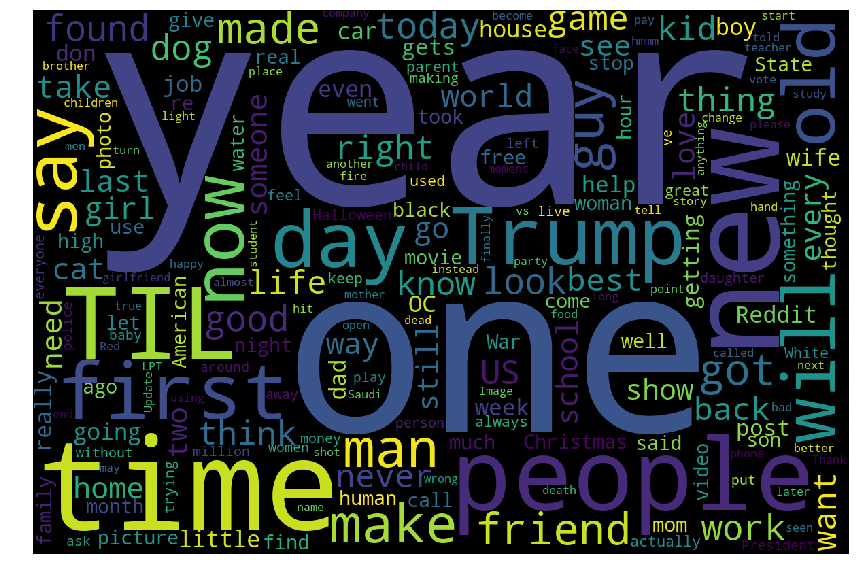

In [15]:
# take all of the headlines of the unique posts and turn them into a wordcloud
reddit_cloud = wordcloud.WordCloud(width=1200, height=800, prefer_horizontal=0.9, max_words=200,
                                   min_font_size=4, collocations=False, colormap="viridis",
                                   background_color="black")

reddit_cloud.generate_from_text(" ".join(unique_posts.headline.tolist()))

plt.imshow(reddit_cloud)
plt.axis("off")
plt.show()

### Top 10 Subreddits with the Most Posts (Unique) on the Front Page

In [180]:
# interactive graph to show top subreddits by unique posts on the entire front page and in certain positions

# top 10 subreddits with the most posts (unique) across the entire front page
top_overall = ordered.groupby("subreddit")["post_id"].nunique().sort_values(ascending=False).reset_index()

data = [go.Bar(
    x = top_overall.subreddit[:10].tolist(),
    y = top_overall.post_id[:10].tolist(),
    name = "Overall",
    marker = {
        "color": top_overall.post_id[:10].tolist(),
        "colorscale": "Portland"
    }
)]
           
# append a figure for each of the top 5 positions
for position in range(0,5):
    # filter data
    relevant_data = ordered[ordered.order == position].groupby(
        "subreddit")["post_id"].nunique().sort_values(ascending=False).reset_index()
    
    # create and figure
    data.append(
        go.Bar(
            x = relevant_data.subreddit[:10].tolist(),
            y = relevant_data.post_id[:10].tolist(),
            name = f"Position {position+1}",
            marker = {
                "color": relevant_data.post_id[:10].tolist(),
                "colorscale": "Portland"
            }
        )
    )
    
updatemenus = [{
    "active": 0,
    "buttons": [{
        "label": "Overall",
        "method": "update",
        "args" : [{"visible": [True, False, False, False, False, False]},
                  {"title": "Subreddits with Most Posts on Front Page"}]
    },
    {
        "label": "Position 1",
        "method": "update",
        "args" : [{"visible": [False, True, False, False, False, False]},
                  {"title": "Subreddits with Most Posts in Position 1"}]
    },
    {
        "label": "Position 2",
        "method": "update",
        "args" : [{"visible": [False, False, True, False, False, False]},
                  {"title": "Subreddits with Most Posts in Position 2"}]
    },
    {
        "label": "Position 3",
        "method": "update",
        "args" : [{"visible": [False, False, False, True, False, False]},
                  {"title": "Subreddits with Most Posts in Position 3"}]
    },
    {
        "label": "Position 4",
        "method": "update",
        "args" : [{"visible": [False, False, False, False, True, False]},
                  {"title": "Subreddits with Most Posts in Position 4"}]
    },
    {
        "label": "Position 5",
        "method": "update",
        "args" : [{"visible": [False, False, False, False, False, True]},
                  {"title": "Subreddits with Most Posts in Position 5"}]
    }
    ]
}]

layout = go.Layout(
    xaxis = {"title": "Subreddits"},
    yaxis = {"title": "No. of Unique Posts"},
    showlegend = False,
    updatemenus = updatemenus
)

figure = go.Figure(data=data, layout=layout)

plotly.offline.iplot(figure, filename="subreddits-most-posts")

### Top 10 Users with the Most Posts (Unique) on the Front Page

In [171]:
# interactive graph to show top users by unique posts on the entire front page and in certain positions

# top 10 users with the most posts across the entire front page
top_overall = ordered.groupby("submitter")["post_id"].nunique().sort_values(ascending=False).reset_index()

data = [go.Bar(
    x = top_overall.submitter[:10].tolist(),
    y = top_overall.post_id[:10].tolist(),
    name = "Overall",
    marker = {
        "color": top_overall.post_id[:10].tolist(),
        "colorscale": "Portland"
    }
)]
           
# append a figure for each of the top 5 positions
for position in range(0,5):
    # filter data
    relevant_data = ordered[ordered.order == position].groupby(
        "submitter")["post_id"].nunique().sort_values(ascending=False).reset_index()
    
    # create and figure
    data.append(
        go.Bar(
            x = relevant_data.submitter[:10].tolist(),
            y = relevant_data.post_id[:10].tolist(),
            name = f"Position {position+1}",
            marker = {
                "color": relevant_data.post_id[:10].tolist(),
                "colorscale": "Portland"
            }
        )
    )
    
updatemenus = [{
    "active": 0,
    "buttons": [{
        "label": "Overall",
        "method": "update",
        "args" : [{"visible": [True, False, False, False, False, False]},
                  {"title": "Users with Most Posts on Front Page"}]
    },
    {
        "label": "Position 1",
        "method": "update",
        "args" : [{"visible": [False, True, False, False, False, False]},
                  {"title": "Users with Most Posts in Position 1"}]
    },
    {
        "label": "Position 2",
        "method": "update",
        "args" : [{"visible": [False, False, True, False, False, False]},
                  {"title": "Users with Most Posts in Position 2"}]
    },
    {
        "label": "Position 3",
        "method": "update",
        "args" : [{"visible": [False, False, False, True, False, False]},
                  {"title": "Users with Most Posts in Position 3"}]
    },
    {
        "label": "Position 4",
        "method": "update",
        "args" : [{"visible": [False, False, False, False, True, False]},
                  {"title": "Users with Most Posts in Position 4"}]
    },
    {
        "label": "Position 5",
        "method": "update",
        "args" : [{"visible": [False, False, False, False, False, True]},
                  {"title": "Users with Most Posts in Position 5"}]
    }
    ]
}]

layout = go.Layout(
    xaxis = {"title": "Users"},
    yaxis = {"title": "No. of Unique Posts"},
    showlegend = False,
    updatemenus = updatemenus
)

figure = go.Figure(data=data, layout=layout)

plotly.offline.iplot(figure, filename="users-most-posts")

### Top 10 Posts that Spent the Most Time on the Front Page

In [ ]:
# to-do

### Average Time (Hours) a Post Spends in Each Position

In [ ]:
# to-do